In [1]:
import trecs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import nnls
from trecs.validate import validate_user_item_inputs
from collections import defaultdict
import warnings
warnings.simplefilter("ignore")

N.B. This notebook is tested for the `chaney_updates` branch of `t-recs` as of 3/16/2021.

# Generate synthetic data

First, we generate all the user / item data that will be used in each of our simulations (including the social network, which is used in the social filtering model). All parameters are from the Chaney et al. paper (see https://arxiv.org/pdf/1710.11214.pdf).

In [2]:
# Define global constants that apply to all simulations

# random seed
GENERATOR = np.random.default_rng(1234)
# parameters from section 5 of paper
NUM_USERS = 100 
NUM_ITEMS = 10000 
NUM_ATTRS = 20 
NUM_SIMS = 5 # CHANGE BACK TO 30 

In [3]:
# generate synthetic user profiles, item attributes, true/noisy user-item utilities
MU_N = 0.98 # parameters provided in paper 
SIGMA = 1e-5

def gen_social_network(user_prefs):
    """ Generates a |U|x|U| social network of connections
        as specified in Chaney et al.
    """
    user_cov = np.cov(user_prefs)
    possible_thresholds = np.sort(user_cov.flatten())[::-1]
    user_connections = None
    num_users = user_prefs.shape[0]
    for thresh in possible_thresholds[num_users:]:
        num_connected = (user_cov >= thresh).any(axis=1).sum()
        if num_connected == num_users:
            return (user_cov >= thresh).astype(int) # final adjacency matrix
    raise RuntimeError("Could not find a suitable threshold.")

    
def mu_sigma_to_alpha_beta(mu, sigma):
    """ For Chaney's custom Beta' function, we convert
        a mean and variance to an alpha and beta parameter
        of a Beta function. See footnote 3 page 3 of Chaney
        et al. for details.
    """
    alpha = ((1-mu) / (sigma**2) - (1/mu)) * mu**2
    beta = alpha * (1/mu - 1)
    return alpha, beta

user_params = GENERATOR.dirichlet(np.ones(NUM_ATTRS), size=NUM_SIMS) * 10
item_params = GENERATOR.dirichlet(np.ones(NUM_ATTRS) * 100, size=NUM_SIMS) * 0.1

# each element in users is the users vector in one simulation
users, items, true_utils, known_utils, social_networks = [], [], [], [], []
for sim_index in range(NUM_SIMS):
    # generate user preferences and item attributes
    user_prefs = GENERATOR.dirichlet(user_params[sim_index, :], size=NUM_USERS) # 100 users
    item_attrs = GENERATOR.dirichlet(item_params[sim_index, :], size=NUM_ITEMS) # 200 items
    
    # mean of the utility distribution
    true_utils_mu = user_prefs @ item_attrs.T
    true_utils_mu = np.clip(true_utils_mu, 1e-9, None) # avoid numerical stability issues
    # sample total utility from a beta distribution
    alphas, betas = mu_sigma_to_alpha_beta(true_utils_mu, SIGMA)
    true_util = GENERATOR.beta(alphas, betas, size=(NUM_USERS, NUM_ITEMS))
    # assert support of true utilities; should be within 0 and 1
    assert true_util.min() >= 0 and true_util.max() <= 1
    
    # calculate known utility for each user
    alpha, beta = mu_sigma_to_alpha_beta(MU_N, SIGMA) # parameters for beta function governing percentage of utility known to users
    perc_known = GENERATOR.beta(alpha, beta, size=(NUM_USERS, NUM_ITEMS))
    known_util = true_util * perc_known 
    
    # add all synthetic data to list
    users.append(user_prefs) 
    social_networks.append(gen_social_network(user_prefs))
    items.append(item_attrs) 
    true_utils.append(true_util)
    known_utils.append(known_util)
    
    
# print shape
print(f"Dimensions of users matrix: {users[0].shape}") # we should see 100 users with 20 attributes
print(f"Dimensions of items matrix: {items[0].shape}") # we should see 1000 items with 20 attributes
print(f"Dimensions of (true) utilities matrix: {true_utils[0].shape}")
print(f"Dimensions of (known) utilities matrix: {known_utils[0].shape}")

Dimensions of users matrix: (100, 20)
Dimensions of items matrix: (10000, 20)
Dimensions of (true) utilities matrix: (100, 10000)
Dimensions of (known) utilities matrix: (100, 10000)


Next, we visualize the true user utilities for each item  to verify that the resulting graph is similar to what appears in the Chaney paper.

Text(0.5, 1.0, 'True user-item utilities (first 250 items)')

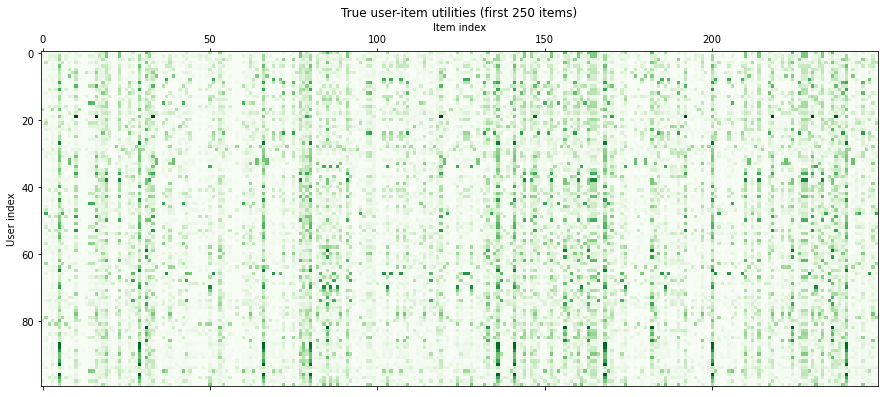

In [4]:
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(true_utils[0][:, :250], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('User index')
ax.set_title("True user-item utilities (first 250 items)")
# this seems reasonably sparse and matches the picture in the Chaney paper! let's proceed

Text(0.5, 1.0, 'User-item utilities (known to user, first 250 items)')

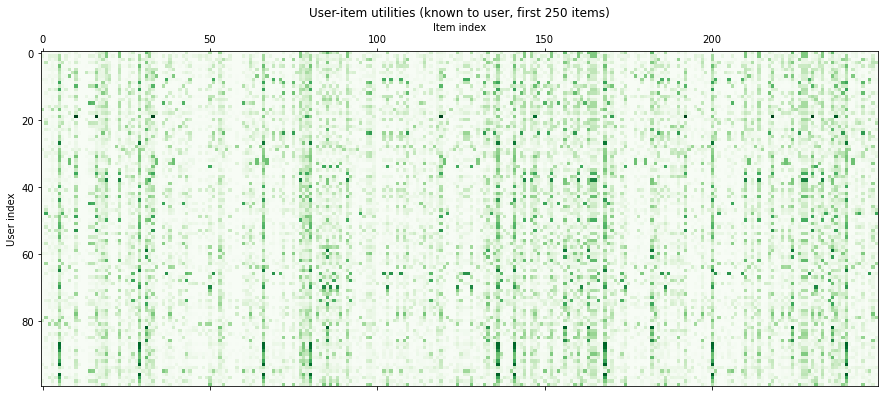

In [5]:
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(known_utils[0][:, :250], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('User index')
ax.set_title("User-item utilities (known to user, first 250 items)")

Text(0.5, 1.0, 'Item attributes of first 250 items')

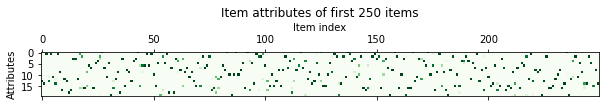

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow((items[0].T)[:, :250], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Attributes')
ax.set_title("Item attributes of first 250 items")

# Custom models/classes/metrics

Next, we create some custom models and metrics that will be used in our replication experiments. Most of the functionality is already in T-RECS, but we "customize" things here so we can measure the same things that Chaney measures. These include:
* Jaccard Similarity for pairs of similar users, where "similar" is defined by cosine similarity of model's internal user representation
* Ideal recommender system
* Random recommender system (randomly recommends items)
* Chaney content filtering system (updates internal representation of users by using `scipy.optimize.nnls` to solve for the least-squares approximation of user attributes)
* Custom content filtering system that "freezes" the model's internal representation of user attributes (important for the Jaccard Similarity metric mentioned earlier)

In [7]:
# necessary imports
from trecs.models import ContentFiltering, PopularityRecommender, ImplicitMF, SocialFiltering
from trecs.components import Users, Items, Creators, ActualUserScores
from trecs.metrics import HomogeneityMeasurement, InteractionSimilarity, Measurement
from trecs.matrix_ops import normalize_matrix, inner_product
from trecs.random import Generator

from sklearn.metrics.pairwise import cosine_similarity

Custom score function that ensures that only the items in the training phase get recommended. The user must manually calculate how many items will be created & shown during the training period and pass this in as `num_items_per_iter`.

In [8]:
def exclude_new_items(num_items_per_iter):
    """ This custom scoring function ensures that all items in the system
        that are created after a certain point are given a score of negative
        infinity, ensuring that they will be at the very bottom of any recommendation
        list.
    """
    # score_fn is called by process_new_items and by train.
    # therefore, when score_fn is being called the first time, we will give all new items 
    # scores of negative infinity; then, when train() is called, the actual
    # scores will be supplied. 
    def score_fn(users, items):
        predicted_scores = inner_product(users, items)
        if items.shape[1] == num_items_per_iter: # EDGE CASE: when num_items_per_iter = num_items
            # all predicted scores for these "new" items will be negative infinity,
            # ensuring they never get recommended
            predicted_scores[:, :] = float('-inf')
        return predicted_scores
    return score_fn

def perfect_scores(num_items_per_iter, true_scores):
    """ This custom scoring function ensures that all items in the system
        that are created after a certain point are given a score of negative
        infinity, ensuring that they will be at the very bottom of any recommendation
        list. Otherwise, we return the "true scores" specified in the
        true_scores array.
    """
    score_copy = np.copy(true_scores)
    def score_fn(users, items):
        predicted_scores = np.copy(score_copy)
        num_users, num_items = users.shape[0], items.shape[1]
        # all predicted scores for these "new" items will be negative infinity,
        # ensuring they never get recommended; instead, they are interleaved into the recommendation
        # set
        predicted_scores = predicted_scores[:num_users, :num_items] # subset to correct dimensions
        if items.shape[1] == num_items_per_iter: # EDGE CASE: when num_items_per_iter = num_items
            # all predicted scores for these "new" items will be negative infinity,
            # ensuring they never get recommended
            predicted_scores[:, :] = float('-inf')
        return predicted_scores
    return score_fn

Custom interleaving method that ensures that all of the most recently created items (i.e., the newest items) are the ones interleaved with the recommendations.

In [9]:
def interleave_new_items(k, item_indices):
    """ Chooses the most recent, newest items to interleave
        with the recommendation set.
    """
    num_users = item_indices.shape[0]
    indices = item_indices[:, -k:]
    values = GENERATOR.random(indices.shape)
    order = values.argsort(axis=1) # randomly sort indices within rows
    rows = np.tile(np.arange(num_users).reshape((-1, 1)), indices.shape[1])
    return indices[rows, order]

This custom "content creator" pumps out new items at every iteration. It starts with the full knowledge of all items at the beginning of the simulation, and then as the simulation progresses, "releases" new items to the RS.

In [10]:
class NewItemFactory(Creators):
    def __init__(self, items, items_per_iteration):
        """ Expects items in matrix of dimension |A| x |I|, where
            |A| is the number of attributes and |I| is the number
            of items.
        """
        self.items = items
        self.items_per_iteration = items_per_iteration
        self.idx = 0
        
    def generate_items(self):
        """ The items generated are simply selected from a particular
            range of indices, which gets incremented at each timestep.
        """
        if self.idx > self.items.shape[1]:
            raise RuntimeError("Ran out of items to generate!")
        idx_start = self.idx
        idx_end = self.idx + self.items_per_iteration
        self.idx = idx_end
        return self.items[:, idx_start:idx_end]

This special subclass of `Users` allows users to know their true scores for all items (even those that haven't been created yet).

In [11]:
class ChaneyUsers(Users):
    def __init__(self, true_scores, *args, **kwargs):
        self.true_scores = np.copy(true_scores) # contains all user-item scores
        super().__init__(*args, **kwargs)
        
    def compute_user_scores(self, items):
        """ No need to do this at initialization - user will be set with scores later.
        """
        self.actual_user_scores = ActualUserScores(self.true_scores)
        
    def score_new_items(self, items):
        """ Chaney users are special - they already know all their
            utility values for all items
        """
        pass
    
    def get_user_feedback(self, *args, **kwargs):
        interactions = super().get_user_feedback(*args, **kwargs)
        return interactions

Custom measurement that measures the Jaccard index of interactions between pairs of users, relative to the ideal recommender.

In [12]:
class InteractionTracker(Measurement):
    """ Tracks all user interactions up to the current timepoint. In the context of replication,
        it will be used to track homogenization of the ideal recommender system.
    """
    def __init__(self, name="interaction_history", verbose=False):
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        interactions = kwargs.pop("interactions", None)
        self.observe(np.copy(interactions).reshape((-1, 1)))

        
def calculate_avg_jaccard(pairs, interactions):
    """ Calculates average Jaccard index over specified pairs of users.
    """
    similarity = 0
    num_pairs = len(pairs)
    for user1, user2 in pairs:
        itemset_1 = set(interactions[user1, :])
        itemset_2 = set(interactions[user2, :])
        common = len(itemset_1.intersection(itemset_2))
        union = len(itemset_1.union(itemset_2))
        similarity += common / union / num_pairs
    return similarity
        
class SimilarUserInteractionSimilarity(Measurement):
    def __init__(self, ideal_interaction_hist, name="similar_user_jaccard", verbose=False):
        self.ideal_hist = ideal_interaction_hist
        self.interaction_hist = None
        self.timestep = 0
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        interactions = kwargs.pop("interactions", None)
        if interactions is None:
            raise ValueError(
                "interactions must be passed in to InteractionSimilarity's `measure` "
                "method as a keyword argument"
            )
        if self.interaction_hist is None:
            self.interaction_hist = np.copy(interactions).reshape((-1, 1))
        else:
            self.interaction_hist = np.hstack([self.interaction_hist, interactions.reshape((-1, 1))])
        # generate cosine similarity matrix for all users
        assert recommender.users_hat.get_timesteps() == self.timestep + 1 # ensure that the users_hat variable is storing copies at each timestep
        user_representation = recommender.users_hat.state_history[-1]
        sim_matrix = cosine_similarity(user_representation, user_representation)
        # set diagonal entries to zero
        num_users = sim_matrix.shape[0]
        sim_matrix[np.arange(num_users), np.arange(num_users)] = 0
        # add random perturbation to break ties
        sim_tiebreak = np.zeros(
            sim_matrix.shape, dtype=[("score", "f8"), ("random", "f8")]
        )
        sim_tiebreak["score"] = sim_matrix
        sim_tiebreak["random"] = GENERATOR.random(sim_matrix.shape)
        # array where element x at index i represents the "most similar" user to user i
        closest_users = np.argsort(sim_tiebreak, axis=1, order=["score", "random"])[:, -1]
        pairs = list(enumerate(closest_users))
        # calculate average jaccard similarity
        ideal_similarity = calculate_avg_jaccard(pairs, self.ideal_hist[:, :(self.timestep + 1)]) # compare
        this_similarity = calculate_avg_jaccard(pairs, self.interaction_hist)
        self.observe(this_similarity - ideal_similarity)
        self.timestep += 1 # increment timestep

In [13]:
# Calculate homogenization by the average Euclidean distance of the interaction set

def avg_interaction_distance(items1, items2, item_attributes):
    """
    Assumes items are provided in timestep order;
    averages the euclidean distance over timesteps.
    
    Assume items matrix is |A| x |I|
    """
    num_steps = len(items1)
    assert len(items1) == len(items2) # should have interacted with same # of itesm
    total_distance = 0
    for i in range(num_steps):
        item1 = item_attributes[:, items1[i]]
        item2 = item_attributes[:, items2[i]]
        total_distance += np.linalg.norm(item1 - item2)
    return total_distance / num_steps

def distance_of_mean_items(items1, items2, item_attributes):
    """
    Returns the difference between the average vector of the items
    in set 1 and the average vector of the items in set 2.
    
    Assume items matrix is |A| x |I|
    """
    mean1 = item_attributes[:, items1].mean(axis=1)
    mean2 = item_attributes[:, items2].mean(axis=1)
    return np.linalg.norm(mean1 - mean2)
    
def mean_item_dist_pairs(pairs, interaction_history, item_attributes):
    """
    For each pair, calculates the distance between the mean item
    interacted with by each member of the pair. Then averages these
    distances across all pairs.
    """
    dist = 0
    for pair in pairs:
        itemset_1 = interaction_history[pair[0], :].flatten()
        itemset_2 = interaction_history[pair[1], :].flatten()
        dist += distance_of_mean_items(itemset_1, itemset_2, item_attributes) / len(pairs)
    return dist

class MeanInteractionDistance(Measurement):
    """
    Cacluates the mean distance between items in each users' recommendation list based on their item attributes
    This class inherits from :class:`.Measurement`.
    Parameters
    -----------
        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.
    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`
        name: str (optional, default: "mean_rec_distance")
            Name of the measurement component.
    """
    def __init__(self, pairs, name="mean_interaction_dist", verbose=False):
        Measurement.__init__(self, name, verbose, init_value=None)
        self.pairs = pairs
        self.interaction_hist = None
        
    def measure(self, recommender, **kwargs):
        """
        TODO
        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.
            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        interactions = kwargs.pop("interactions", None)
        if interactions is None:
            raise ValueError(
                "interactions must be passed in to InteractionSimilarity's `measure` "
                "method as a keyword argument"
            )
        if self.interaction_hist is None:
            self.interaction_hist = np.copy(interactions).reshape((-1, 1))
        else:
            self.interaction_hist = np.hstack([self.interaction_hist, interactions.reshape((-1, 1))])
        
        avg_dist = mean_item_dist_pairs(self.pairs, self.interaction_hist, recommender.actual_item_attributes)
        self.observe(avg_dist)
        
class MeanDistanceSimUsers(Measurement):
    """
    Cacluates the mean distance between items in each users' recommendation list based on their item attributes
    This class inherits from :class:`.Measurement`.
    Parameters
    -----------
        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.
    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`
        name: str (optional, default: "mean_rec_distance")
            Name of the measurement component.
    """
    def __init__(self, ideal_interaction_hist, ideal_item_attrs, name="sim_user_dist", verbose=False):
        self.ideal_hist = ideal_interaction_hist
        self.ideal_item_attrs = ideal_item_attrs
        self.interaction_hist = None
        self.timestep = 0
        Measurement.__init__(self, name, verbose, init_value=None)
        
    def measure(self, recommender, **kwargs):
        """
        TODO
        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.
            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        interactions = kwargs.pop("interactions", None)
        if interactions is None:
            raise ValueError(
                "interactions must be passed in to InteractionSimilarity's `measure` "
                "method as a keyword argument"
            )
        if self.interaction_hist is None:
            self.interaction_hist = np.copy(interactions).reshape((-1, 1))
        else:
            self.interaction_hist = np.hstack([self.interaction_hist, interactions.reshape((-1, 1))])
        
        # get value of user matrix
        user_representation = recommender.users_hat.state_history[-1]
        # find most similar users
        sim_matrix = cosine_similarity(user_representation, user_representation)
        # set diagonal entries to zero
        num_users = sim_matrix.shape[0]
        sim_matrix[np.arange(num_users), np.arange(num_users)] = 0
        # add random perturbation to break ties
        sim_tiebreak = np.zeros(
            sim_matrix.shape, dtype=[("score", "f8"), ("random", "f8")]
        )
        sim_tiebreak["score"] = sim_matrix
        sim_tiebreak["random"] = GENERATOR.random(sim_matrix.shape)
        # array where element x at index i represents the "most similar" user to user i
        closest_users = np.argsort(sim_tiebreak, axis=1, order=["score", "random"])[:, -1]
        pairs = list(enumerate(closest_users))
        # calculate average jaccard similarity
        ideal_hist = self.ideal_hist[:, :(self.timestep + 1)]
        ideal_dist = mean_item_dist_pairs(pairs, ideal_hist, self.ideal_item_attrs)
        this_dist = mean_item_dist_pairs(pairs, self.interaction_hist, recommender.actual_item_attributes)
        self.observe(this_dist - ideal_dist)
        self.timestep += 1 # increment timestep

In [14]:
# basically just recommends items based on the estimates of user preferences!
# this will form the basis of our "ideal" recommender
class IdealRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        pass
    
    def process_new_items(self, new_items):
        """
        Generate zero attributes for new items. Remember,
        this doesn't actually matter because the IdealRecommender
        uses its perfect score function, not a dot product
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation


In [15]:
# example usage of ideal recommender
true_prefs = users[0] # underlying true preferences
true_scores = true_utils[0]
noisy_scores = known_utils[0]

u = Users(actual_user_scores = noisy_scores, size=(NUM_USERS, NUM_ATTRS), num_users=NUM_USERS) # each user interacts with items based on their (noisy) knowledge of their own scores
ideal_rec = IdealRecommender(item_representation=items[0].T, actual_user_representation=u, score_fn=perfect_scores(0, true_scores))
ideal_rec.startup_and_train(timesteps=10)
ideal_rec.run(
    timesteps=10,
    train_between_steps=False, 
    random_items_per_iter=ideal_rec.num_items_per_iter, 
    vary_random_items_per_iter=True
)

# run some sanity checks to ensure that nothing was altered during simulation
np.testing.assert_array_equal(u.actual_user_scores.value, noisy_scores)
# check that actual user scores as a percentage of the true utilities
# is the same as the known util percentages
np.testing.assert_array_equal(true_scores, ideal_rec.predicted_scores.value)

100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


In [16]:
# random recommender - randomly update users at every step
class RandomRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        self.items_hat.value[:, :] = GENERATOR.random(self.items_hat.shape)
        self.users_hat.value[:, :] = GENERATOR.random(self.users_hat.shape)
        
    def process_new_items(self, new_items):
        """
        Generate random attributes for new items.
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.value.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation

In [17]:
# Chaney ContentFiltering - uses NNLS solver
class ChaneyContent(ContentFiltering):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def _update_internal_state(self, interactions):
        # update cumulative interactions
        num_new_items = self.items_hat.shape[1] - self.cumulative_interactions.shape[1] # how many new items were added to the system?
        if num_new_items > 0:
            self.cumulative_interactions = np.hstack([self.cumulative_interactions, np.zeros((self.num_users, num_new_items))]) # add new items to cumulative interactions
        self.cumulative_interactions[self.users.user_vector, interactions] += 1
        
    def train(self):
        if hasattr(self, 'cumulative_interactions') and self.cumulative_interactions.sum() > 0: # if there are interactions present:
            items_to_train = self.cumulative_interactions.shape[1] # can't train representations for new items before interactions have happened!
            for i in range(self.num_users):
                item_attr = self.items_hat.value[:, :items_to_train].T
                self.users_hat.value[i, :] = nnls(item_attr, self.cumulative_interactions[i, :])[0] # solve for Content Filtering representation using nnls solver
            num_new_items = self.items_hat.shape[1] - self.cumulative_interactions.shape[1] # how many new items were added to the system?
            
        else:
            self.cumulative_interactions = np.zeros((self.users_hat.shape[0], self.items_hat.shape[1]))
        super().train()
        

In [18]:
# utility function to extract measurement
def process_measurement(model, metric_string):
    return model.get_measurements()[metric_string][1:]

# Repeated Training

Now, we actually run the recommender system models on the synthetic datasets. After each model finishes running, we extract two measures of homogenization (change in Jaccard index averaged over pairs of users that are randomly chosen, and the change in Jaccard index averaged over pairs of users that are most similar to each other by cosine similarity).

Note that this is the "repeated training" case, where algorithms are repeatedly updated with new data at each iteration. 

In [19]:
STARTUP_ITERS = 10
SIM_ITERS = 90
NEW_ITEMS_PER_ITER = 10
TOTAL_ITEMS_IN_STARTUP = NEW_ITEMS_PER_ITER * STARTUP_ITERS
ATTENTION_EXP = -0.8 # from Chaney paper, attention function is f(n) = n^(-0.8)

# simpler way to pass common arguments
init_params = {
    "num_items_per_iter": NEW_ITEMS_PER_ITER,
    "num_users": NUM_USERS,
    "num_items": 0, # all simulations start with 0 items
    "interleaving_fn": interleave_new_items,
}

run_params = {
    "random_items_per_iter": NEW_ITEMS_PER_ITER,
    "vary_random_items_per_iter": False,
}

def initialize_users_and_items(known_scores, all_items):
    # each user interacts with items based on their (noisy) knowledge of their own scores
    # user choices also depend on the order of items they are recommended
    u = ChaneyUsers(np.copy(known_scores), size=(NUM_USERS, NUM_ATTRS), num_users=NUM_USERS, attention_exp=ATTENTION_EXP, repeat_interactions=False)
    item_factory = NewItemFactory(np.copy(all_items), NEW_ITEMS_PER_ITER)
    empty_item_set = np.array([]).reshape((NUM_ATTRS, 0)) # initialize empty item set
    return u, item_factory, empty_item_set


def run_ideal_sim(user_prefs, item_attrs, true_utils, noisy_utilities, pairs, repeated_training):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    if repeated_training:
        post_startup_rec_size = "all"
    else: # only serve items that were in the initial training set
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved itmes
    ideal = IdealRecommender(
        user_representation=user_prefs,
        creators=item_factory, 
        actual_user_representation=u,
        actual_item_representation=empty_items,
        score_fn=perfect_scores(NEW_ITEMS_PER_ITER, true_utils),
        **init_params
    )
    ideal.add_metrics(InteractionSimilarity(pairs), MeanInteractionDistance(pairs), InteractionTracker())
    ideal.startup_and_train(timesteps=STARTUP_ITERS)
    ideal.set_num_items_per_iter(post_startup_rec_size) # show all items from training set plus interleaved itmes
    ideal.close() # end logging
    ideal.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, **run_params)
    return ideal

def run_content_sim(item_attrs, noisy_utilities, pairs, ideal_interactions, repeated_training):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    if not repeated_training:
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved items
    else: # only serve items that were in the initial trainin gset
        post_startup_rec_size = "all"
    chaney = ChaneyContent(
        creators=item_factory, 
        num_attributes=NUM_ATTRS, 
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        score_fn=exclude_new_items(NEW_ITEMS_PER_ITER),
        **init_params)
    metrics = [
        InteractionSimilarity(pairs), 
        MeanInteractionDistance(pairs), 
        SimilarUserInteractionSimilarity(ideal_interactions),
        MeanDistanceSimUsers(ideal_interactions, item_attrs)
    ]
    chaney.add_metrics(*metrics)
    chaney.add_state_variable(chaney.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    chaney.startup_and_train(timesteps=STARTUP_ITERS) # update user representations, but only serve random items
    chaney.set_num_items_per_iter(post_startup_rec_size) # show all items from training set plus interleaved itmes
    chaney.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, **run_params)
    chaney.close() # end logging
    return chaney
    
def run_mf_sim(item_attrs, noisy_utilities, pairs, ideal_interactions, repeated_training):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    if not repeated_training:
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved items
    else: # only serve items that were in the initial trainin gset
        post_startup_rec_size = "all"
    mf = ImplicitMF(
        creators=item_factory,
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        num_latent_factors=NUM_ATTRS,
        score_fn=exclude_new_items(NEW_ITEMS_PER_ITER),
        **init_params
    )
    metrics = [
        InteractionSimilarity(pairs), 
        MeanInteractionDistance(pairs), 
        SimilarUserInteractionSimilarity(ideal_interactions),
        MeanDistanceSimUsers(ideal_interactions, item_attrs)
    ]
    mf.add_metrics(*metrics)
    mf.add_state_variable(mf.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    mf.startup_and_train(timesteps=STARTUP_ITERS, no_new_items=False) # update user representations, but only serve random items
    mf.set_num_items_per_iter(post_startup_rec_size) # show all items from training set plus interleaved itmes
    mf.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, reset_interactions=False, **run_params)
    mf.close() # end logging
    return mf
    
    
def run_sf_sim(social_network, item_attrs, noisy_utilities, pairs, ideal_interactions, repeated_training):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    if not repeated_training:
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved items
    else: # only serve items that were in the initial trainin gset
        post_startup_rec_size = "all"
    sf = SocialFiltering(
        creators=item_factory,
        user_representation=social_network, 
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        score_fn=exclude_new_items(NEW_ITEMS_PER_ITER),
        **init_params
    )
    metrics = [
        InteractionSimilarity(pairs), 
        MeanInteractionDistance(pairs), 
        SimilarUserInteractionSimilarity(ideal_interactions),
        MeanDistanceSimUsers(ideal_interactions, item_attrs)
    ]
    sf.add_metrics(*metrics)
    sf.add_state_variable(sf.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    sf.startup_and_train(timesteps=STARTUP_ITERS)
    sf.set_num_items_per_iter(post_startup_rec_size) # show all items from training set plus interleaved itmes
    sf.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, **run_params)
    sf.close() # end logging
    return sf

def run_pop_sim(item_attrs, noisy_utilities, pairs, ideal_interactions, repeated_training):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    if not repeated_training:
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved items
    else: # only serve items that were in the initial trainin gset
        post_startup_rec_size = "all"
    p = PopularityRecommender(
        creators=item_factory,
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        score_fn=exclude_new_items(NEW_ITEMS_PER_ITER),
        **init_params
    )
    metrics = [
        InteractionSimilarity(pairs), 
        MeanInteractionDistance(pairs), 
        SimilarUserInteractionSimilarity(ideal_interactions),
        MeanDistanceSimUsers(ideal_interactions, item_attrs)
    ]
    p.add_metrics(*metrics)
    p.add_state_variable(p.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    p.startup_and_train(timesteps=STARTUP_ITERS)
    p.set_num_items_per_iter(post_startup_rec_size)
    p.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, **run_params)
    p.close() # end logging
    return p
    
def run_random_sim(item_attrs, noisy_utilities, pairs, ideal_interactions, repeated_training):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    if not repeated_training:
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved items
    else: # only serve items that were in the initial trainin gset
        post_startup_rec_size = "all"
    r = RandomRecommender(
        creators=item_factory,
        num_attributes=NUM_ATTRS,
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        score_fn=exclude_new_items(NEW_ITEMS_PER_ITER),
        **init_params
    )
    metrics = [
        InteractionSimilarity(pairs), 
        MeanInteractionDistance(pairs), 
        SimilarUserInteractionSimilarity(ideal_interactions),
        MeanDistanceSimUsers(ideal_interactions, item_attrs)
    ]
    r.add_metrics(*metrics) # random pairing of users
    r.add_state_variable(r.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    r.startup_and_train(timesteps=STARTUP_ITERS)
    r.set_num_items_per_iter(post_startup_rec_size)
    # train between steps because we make the user representations random every time
    r.run(timesteps=SIM_ITERS, train_between_steps=True, **run_params)
    r.close() # end logging
    return r

In [20]:
model_keys = ["ideal", "content_chaney", "mf", "sf", "popularity", "random"]
# stores results for each type of model for each type of user pairing (random or cosine similarity)
rep_train_results = {"sim_users": defaultdict(list), "random_users": defaultdict(list), "mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}
rep_train_models = {}

for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    true_scores = true_utils[i]
    noisy_scores = known_utils[i]
    item_representation = items[i].T
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
        
    repeated_training = True
    rep_train_models["ideal"] = run_ideal_sim(true_prefs, item_representation, true_scores, noisy_scores, pairs, repeated_training)
    ideal_interactions = np.hstack(process_measurement(rep_train_models["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    rep_train_models["content_chaney"] = run_content_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    rep_train_models["mf"] = run_mf_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    rep_train_models["sf"] = run_sf_sim(social_network, item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    rep_train_models["popularity"] = run_pop_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    rep_train_models["random"] = run_random_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    
    # extract results from each model
    for model_key in model_keys:
        model = rep_train_models[model_key]
        rep_train_results["random_users"][model_key].append(process_measurement(model, "interaction_similarity"))
        rep_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            rep_train_results["sim_users"][model_key].append(process_measurement(model, "similar_user_jaccard"))
            rep_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

100%|██████████| 90/90 [00:15<00:00,  5.96it/s]


In [104]:
# graphing
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 14})

# smoothing factor for visualizing curves
sigma = 1

## Change in Jaccard (users paired randomly)

In [22]:
# get change in jaccard index just for ideal recommender
ideal_jaccard = np.array(rep_train_results["random_users"]["ideal"])
relative_jaccard = {}

for model_key in model_keys:
    abs_jaccard = np.array(rep_train_results["random_users"][model_key])
    relative_jaccard[model_key] = (abs_jaccard - ideal_jaccard).mean(axis=0) # average across 10 trials

In [107]:
# readable legend keys
id_to_readable = {
    "ideal": "ideal", 
    "content_chaney": "content (Chaney et al.)",
    "mf" : "matrix factorization",
    "sf": "social filtering",
    "popularity": "popularity", 
    "random": "random"
}

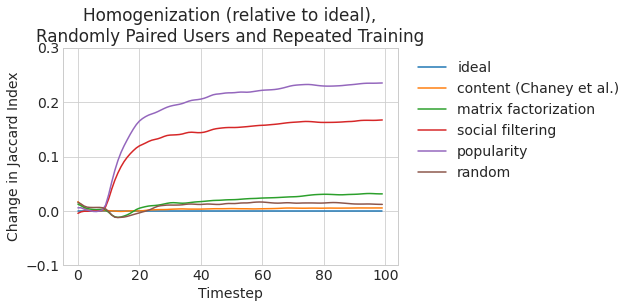

In [24]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.1, 0.3)
plt.title("Homogenization (relative to ideal),\nRandomly Paired Users and Repeated Training")
plt.savefig('repeated_training_random_pair.pdf', bbox_inches = "tight")

## Change in Jaccard (similar users paired)

In [25]:
# get change in jaccard index just for ideal recommender
relative_jaccard = {}
relative_jaccard["ideal"] = np.zeros(STARTUP_ITERS + SIM_ITERS)

for model_key in model_keys:
    if model_key is not "ideal":
        relative_jaccard[model_key] = (np.array(rep_train_results["sim_users"][model_key])).mean(axis=0) # average across 10 trials

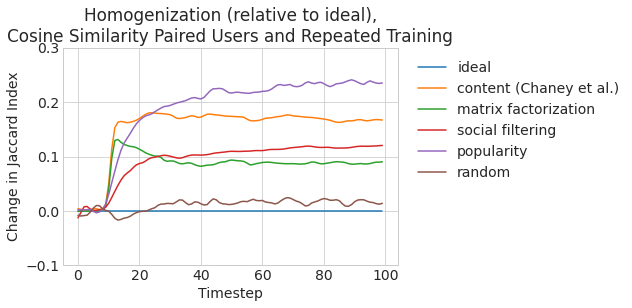

In [26]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.1, 0.3)
plt.title("Homogenization (relative to ideal),\nCosine Similarity Paired Users and Repeated Training")
plt.savefig('repeated_training_sim_pair.pdf', bbox_inches = "tight")

## Average distance between mean items

In [27]:
# get change in jaccard index just for ideal recommender
ideal_dist = np.array(rep_train_results["mean_item_dist"]["ideal"])
relative_dist = {}

for model_key in model_keys:
    abs_dist = np.array(rep_train_results["mean_item_dist"][model_key])
    relative_dist[model_key] = (abs_dist - ideal_dist).mean(axis=0) # average across 10 trials

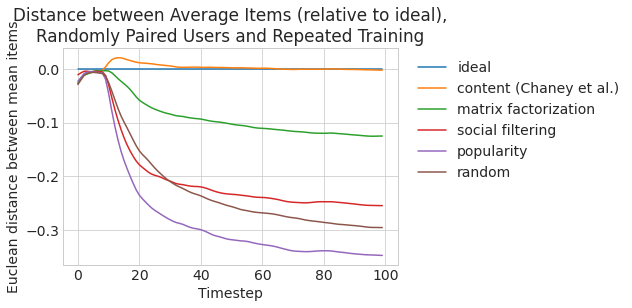

In [28]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Euclean distance between mean items")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
# plt.ylim(-0.1, 0.3)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Repeated Training")
plt.savefig('repeated_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

## Change in Mean Item Distance (similar users paired)

In [29]:
# get change in jaccard index just for ideal recommender
relative_dist = {}
relative_dist["ideal"] = np.zeros(STARTUP_ITERS + SIM_ITERS)

for model_key in model_keys:
    if model_key is not "ideal":
        relative_dist[model_key] = (np.array(rep_train_results["sim_user_dist"][model_key])).mean(axis=0) # average across 10 trials

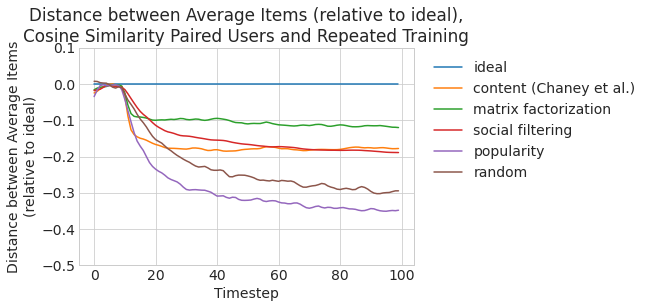

In [30]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nCosine Similarity Paired Users and Repeated Training")
plt.savefig('repeated_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")

# Single training

We do the same training with all of the same models just as we did earlier, but now we only train each model once - following the startup phase.

In [31]:
# stores results for each type of model for each type of user pairing (random or cosine similarity)
single_train_results = {"sim_users": defaultdict(list), "random_users": defaultdict(list), "mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}

STARTUP_ITERS = 50
SIM_ITERS = 50

for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    true_scores = true_utils[i]
    noisy_scores = known_utils[i]
    item_representation = items[i].T
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
    
    repeated_training = False
    single_train_results["ideal"] = run_ideal_sim(true_prefs, item_representation, true_scores, noisy_scores, pairs, repeated_training)
    ideal_interactions = np.hstack(process_measurement(single_train_results["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    single_train_results["content_chaney"] = run_content_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    single_train_results["mf"] = run_mf_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    single_train_results["sf"] = run_sf_sim(social_network, item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    single_train_results["popularity"] = run_pop_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    single_train_results["random"] = run_random_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    
    # extract results from each model
    for model_key in model_keys:
        model = single_train_results[model_key]
        single_train_results["random_users"][model_key].append(process_measurement(model, "interaction_similarity"))
        single_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            single_train_results["sim_users"][model_key].append(process_measurement(model, "similar_user_jaccard"))
            single_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


## Change in Jaccard (users paired randomly)

In [32]:
# get change in jaccard index just for ideal recommender
ideal_jaccard = np.array(single_train_results["random_users"]["ideal"])
relative_jaccard = {}

for model_key in model_keys:
    abs_jaccard = np.array(single_train_results["random_users"][model_key])
    relative_jaccard[model_key] = (abs_jaccard - ideal_jaccard).mean(axis=0) # average across 10 trials

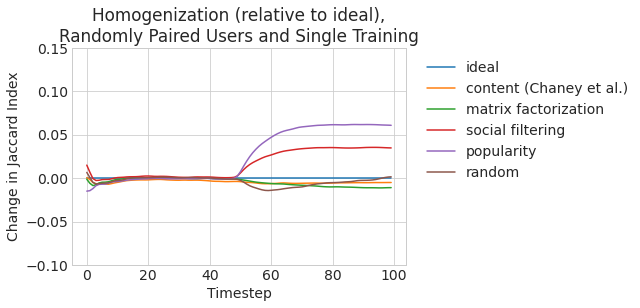

In [33]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.1, 0.15)
plt.title("Homogenization (relative to ideal),\nRandomly Paired Users and Single Training")
plt.savefig('single_training_random_pair.pdf', bbox_inches = "tight")

## Change in Jaccard (similar users paired)

In [34]:
# get change in jaccard index just for ideal recommender
relative_jaccard = {}
relative_jaccard["ideal"] = np.zeros(STARTUP_ITERS + SIM_ITERS)

for model_key in model_keys:
    if model_key is not "ideal":
        relative_jaccard[model_key] = (np.array(single_train_results["sim_users"][model_key])).mean(axis=0) # average across 10 trials

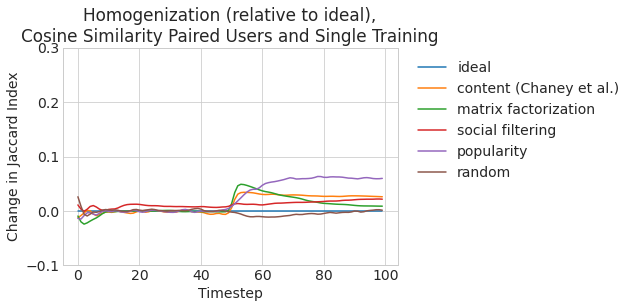

In [35]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.title("Homogenization (relative to ideal),\nCosine Similarity Paired Users and Single Training")
plt.ylim(-0.1, 0.3)
plt.savefig('single_training_sim_pair.pdf', bbox_inches = "tight")

## Average distance between mean items

In [36]:
# get change in jaccard index just for ideal recommender
ideal_dist = np.array(single_train_results["mean_item_dist"]["ideal"])
relative_dist = {}

for model_key in model_keys:
    abs_dist = np.array(single_train_results["mean_item_dist"][model_key])
    relative_dist[model_key] = (abs_dist - ideal_dist).mean(axis=0) # average across 10 trials

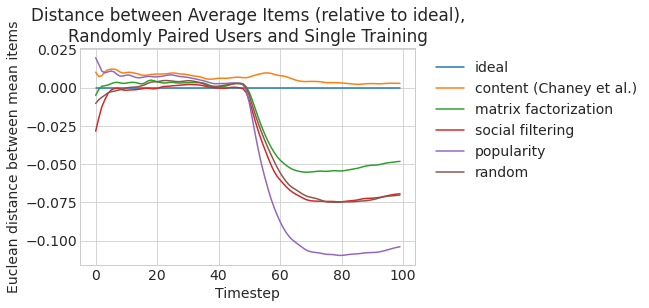

In [37]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Euclean distance between mean items")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
# plt.ylim(-0.1, 0.3)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Single Training")
plt.savefig('single_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

## Change in Mean Item Distance (similar users paired)

In [38]:
# get change in jaccard index just for ideal recommender
relative_dist = {}
relative_dist["ideal"] = np.zeros(STARTUP_ITERS + SIM_ITERS)

for model_key in model_keys:
    if model_key is not "ideal":
        relative_dist[model_key] = (np.array(single_train_results["sim_user_dist"][model_key])).mean(axis=0) # average across 10 trials

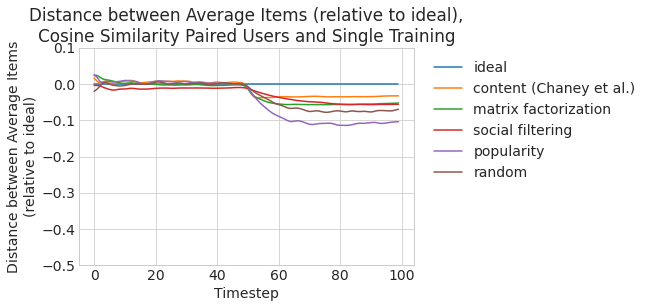

In [39]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nCosine Similarity Paired Users and Single Training")
plt.savefig('single_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")

# Content creators
(**N.B.**: this may need to be moved to a different notebook)

In [110]:
class ChaneyCreators(Creators):
    def __init__(self, items_per_creator, learning_rate=0.05, **kwargs):
        """ 
        TODO: documentation
        """
        # all creators make items at every iteration
        self.items_per_creator = items_per_creator
        self.learning_rate = learning_rate
        super().__init__(**kwargs)
        self.rng = Generator(seed=self.seed)
        self.ordered_creator_ids = np.array([])
        
    def generate_items(self):
        """ 
        All content creators create at every step
        """
        num_creators, num_attrs = self.actual_creator_profiles.shape
        creator_mask = self.rng.binomial(
            1, self.creation_probability, self.actual_creator_profiles.shape[0]
        )
        chosen_profiles = np.nonzero(creator_mask)[0].astype(int)  # keep track of who created the items
        self.ordered_creator_ids = np.append(
            self.ordered_creator_ids, np.repeat(chosen_profiles, self.items_per_creator)
        )
        items = np.zeros((self.items_per_creator * num_creators, num_attrs))
        # TODO: ADD BACK IN
        for idx, c in enumerate(chosen_profiles):
            # generate item from creator
            next_idx = (idx+1) * self.items_per_creator
            # 0.1 multiplier helps maintain sparsity
            items[idx:next_idx, :] = self.rng.dirichlet(self.actual_creator_profiles[c, :] * 0.1, size=self.items_per_creator)
        return items.T
    
    def update_profiles(self, interactions, items):
        """
        Update each creator's profile by the items that gained interaction
        that were made by that creator.

        Parameters
        -----------

            interactions: numpy.ndarray or list
                A matrix where row `i` corresponds to the attribute vector
                that user `i` interacted with.
        """
        # total number of items should be equal to length of ordered_creator_ids
        assert len(self.ordered_creator_ids) == items.shape[1]
        # collapse interactions
        item_ids = interactions.reshape(-1) # readjust indices
        creators_to_update = self.ordered_creator_ids[item_ids].astype(int)
        # note that we remove the last attribute
        weighted_items = (self.learning_rate * items[:, item_ids]).T

        # update the rows at index creators_to_update by adding
        # the rows corresponding to the items they created
        np.add.at(self.actual_creator_profiles, (creators_to_update, slice(None)), weighted_items)
        # normalize creators
        self.actual_creator_profiles /= self.actual_creator_profiles.sum(axis=1)[:, np.newaxis]
        self.actual_creator_profiles = np.clip(self.actual_creator_profiles, 1e-4, 1) # prevent values from getting too low

In [111]:
# generates user scores on the fly
def ideal_content_score_fns(sigma, mu_n, num_items_per_iter, generator):
    """
    This is the scoring function used for the Ideal Recommender when content creators are introduced.
    This is necessary because scores are generated for items on the fly, rather than being generated
    at the beginning of the simulation.
    
    Returns the score function for the model and the score function for the users.
    """
    alpha, beta = mu_sigma_to_alpha_beta(mu_n, sigma)
    # start with empty array
    true_user_item_utils = None
    def model_score_fn(user_attrs, item_attrs):
        # generate utils for new items
        nonlocal true_user_item_utils
        num_users, num_items = user_attrs.shape[0], item_attrs.shape[1]
        if true_user_item_utils is None:
            # initialize empty user item score array
            true_user_item_utils = np.array([]).reshape((num_users, num_items))
        if item_attrs.shape[1] == num_items_per_iter: # EDGE CASE: when num_items_per_iter = num_items
            true_utils_mean = user_attrs @ item_attrs
            true_utils_mean = np.clip(true_utils_mean, 1e-9, None)
            user_alphas, user_betas = mu_sigma_to_alpha_beta(true_utils_mean, sigma)
            true_utility = generator.beta(user_alphas, user_betas, size=(num_users, num_items))
            true_user_item_utils = np.hstack((true_user_item_utils, true_utility))
            # all predicted scores for these "new" items will be negative infinity,
            # ensuring they never get recommended
            return np.ones(true_user_item_utils.shape) * float('-inf')
        else:
            # assume this is when train() was called on the entire item set
            assert (num_users, num_items) == true_user_item_utils.shape
            return true_user_item_utils[:num_users, :num_items].copy() # subset to correct dimensions
        
    def user_score_fn(user_profiles, item_attributes):
        """
        The function that calculates user scores depends on the true utilities,
        which are generated during the `model_score_fn` step.
        """
        nonlocal alpha
        nonlocal beta
        num_items = item_attributes.shape[1]
        num_users = user_profiles.shape[0]
        # calculate percentage of utility known
        perc_util_known = generator.beta(alpha, beta, size=(num_users, num_items))
        # get the true utilities for the items that were just created;
        # they should be the most recently added items to the user-item
        # score matrix - this is only true for the ideal recommender
        true_utility = true_user_item_utils[:, -num_items:]
        known_utility = true_utility * perc_util_known
        return known_utility
    
    return model_score_fn, user_score_fn

class IdealContentRecommender(ContentFiltering):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        pass


In [112]:
def user_score_fn(rec, mu_n, sigma, generator):
    alpha, beta = mu_sigma_to_alpha_beta(mu_n, sigma)
    def score_fn(user_profiles, item_attributes):
        nonlocal alpha
        nonlocal beta
        num_items = item_attributes.shape[1]
        num_users = user_profiles.shape[0]
        # calculate percentage of utility known
        perc_util_known = generator.beta(alpha, beta, size=(num_users, num_items))
        true_utils_mean = user_profiles @ item_attributes
        true_utils_mean = np.clip(true_utils_mean, 1e-9, None)
        user_alphas, user_betas = mu_sigma_to_alpha_beta(true_utils_mean, sigma)
        true_utility = generator.beta(user_alphas, user_betas, size=(num_users, num_items))
        known_utility = true_utility * perc_util_known
        return known_utility
        
    return score_fn

In [113]:
# define constants
GENERATOR = np.random.default_rng(1234)
# parameters from section 5 of paper
NUM_USERS = 100 # TODO: CHANGE BACK TO 100
NUM_CREATORS = 10 # TODO: CHANGE BACK TO 10
NUM_ATTRS = 20 # TODO: CHANGE BACK TO 20
NUM_SIMS = 30 # TODO: CHANGE BACK TO 30

In [114]:
user_params = GENERATOR.dirichlet(np.ones(NUM_ATTRS), size=NUM_SIMS) * 10

# each element in users is the users vector in one simulation
users, creators, social_networks = [], [], []
for sim_index in range(NUM_SIMS):
    # generate user preferences and item attributes
    user_prefs = GENERATOR.dirichlet(user_params[sim_index, :], size=NUM_USERS) # 100 users
    creator_attrs = GENERATOR.dirichlet(np.ones(NUM_ATTRS) * 10, size=NUM_CREATORS)
    
    # add all synthetic data to list
    users.append(user_prefs) 
    social_networks.append(gen_social_network(user_prefs))
    creators.append(creator_attrs) 


In [115]:
STARTUP_ITERS = 10
SIM_ITERS = 90
ITEMS_PER_CREATOR = 1
NEW_ITEMS_PER_ITER = ITEMS_PER_CREATOR * NUM_CREATORS
TOTAL_ITEMS_IN_STARTUP = NEW_ITEMS_PER_ITER * STARTUP_ITERS
ATTENTION_EXP = -0.8 # from Chaney paper, attention function is f(n) = n^(-0.8)
LEARNING_RATE = 0.0005

# simpler way to pass common arguments
init_params = {
    "num_items_per_iter": NEW_ITEMS_PER_ITER,
    "num_users": NUM_USERS,
    "num_items": 0, # all simulations start with 0 items
    "interleaving_fn": interleave_new_items,
}

run_params = {
    "random_items_per_iter": NEW_ITEMS_PER_ITER,
    "vary_random_items_per_iter": False,
}

def initialize_users_and_creators(user_profiles, creator_profiles):
    # each user interacts with items based on their (noisy) knowledge of their own scores
    # user choices also depend on the order of items they are recommended
    u = Users(actual_user_profiles=user_profiles, size=(NUM_USERS, NUM_ATTRS), num_users=NUM_USERS, attention_exp=ATTENTION_EXP, repeat_interactions=False)
    c = ChaneyCreators(ITEMS_PER_CREATOR, actual_creator_profiles=creator_profiles.copy(), creation_probability=1.0, learning_rate=LEARNING_RATE)
    empty_item_set = np.array([]).reshape((NUM_ATTRS, 0)) # initialize empty item set
    return u, c, empty_item_set


def run_ideal_sim(user_prefs, creator_profiles, pairs, repeated_training):
    u, c, empty_items = initialize_users_and_creators(user_prefs, creator_profiles)
    if repeated_training:
        post_startup_rec_size = "all"
    else: # only serve items that were in the initial training set
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved itmes
    model_score_fn, user_score_fn = ideal_content_score_fns(SIGMA, MU_N, NEW_ITEMS_PER_ITER, GENERATOR)
    ideal = IdealContentRecommender(
        user_representation=user_prefs,
        creators=c, 
        actual_user_representation=u,
        actual_item_representation=empty_items,
        score_fn=model_score_fn,
        **init_params
    )
    # set score function here because it requires a reference to the recsys
    ideal.users.set_score_function(user_score_fn)
    ideal.add_metrics(MeanInteractionDistance(pairs), InteractionTracker())
    ideal.startup_and_train(timesteps=STARTUP_ITERS)
    ideal.set_num_items_per_iter(post_startup_rec_size) # show all items from training set plus interleaved itmes
    ideal.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, **run_params)
    ideal.close()
    return ideal

def run_content_sim(user_prefs, creator_profiles, pairs, ideal_interactions, ideal_item_attrs, repeated_training):
    u, c, empty_items = initialize_users_and_creators(user_prefs, creator_profiles)
    if not repeated_training:
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved items
    else: # only serve items that were in the initial trainin gset
        post_startup_rec_size = "all"
    chaney = ChaneyContent(
        creators=c, 
        num_attributes=NUM_ATTRS, 
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        score_fn=exclude_new_items(NEW_ITEMS_PER_ITER),
        **init_params)
    # set score function here because it requires a reference to the recsys
    chaney.users.set_score_function(user_score_fn(chaney, MU_N, SIGMA, GENERATOR))
    metrics = [
        MeanInteractionDistance(pairs), 
        MeanDistanceSimUsers(ideal_interactions, ideal_item_attrs)
    ]
    chaney.add_metrics(*metrics)
    chaney.add_state_variable(chaney.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    chaney.startup_and_train(timesteps=STARTUP_ITERS) # update user representations, but only serve random items
    chaney.set_num_items_per_iter(post_startup_rec_size) # show all items from training set plus interleaved itmes
    chaney.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, **run_params)
    chaney.close() # end logging
    return chaney
    
def run_mf_sim(user_prefs, creator_profiles, pairs, ideal_interactions, ideal_item_attrs, repeated_training):
    u, c, empty_items = initialize_users_and_creators(user_prefs, creator_profiles)
    if not repeated_training:
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved items
    else: # only serve items that were in the initial trainin gset
        post_startup_rec_size = "all"
    mf = ImplicitMF(
        creators=c,
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        num_latent_factors=NUM_ATTRS,
        score_fn=exclude_new_items(NEW_ITEMS_PER_ITER),
        **init_params
    )
    # set score function here because it requires a reference to the recsys
    mf.users.set_score_function(user_score_fn(mf, MU_N, SIGMA, GENERATOR))
    metrics = [
        MeanInteractionDistance(pairs), 
        MeanDistanceSimUsers(ideal_interactions, ideal_item_attrs)
    ]
    mf.add_metrics(*metrics)
    mf.add_state_variable(mf.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    mf.startup_and_train(timesteps=STARTUP_ITERS, no_new_items=False) # update user representations, but only serve random items
    mf.set_num_items_per_iter(post_startup_rec_size) # show all items from training set plus interleaved itmes
    mf.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, reset_interactions=False, **run_params)
    mf.close() # end logging
    return mf
    
    
def run_sf_sim(social_network, user_prefs, creator_profiles, pairs, ideal_interactions, ideal_item_attrs, repeated_training):
    u, c, empty_items = initialize_users_and_creators(user_prefs, creator_profiles)
    if not repeated_training:
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved items
    else: # only serve items that were in the initial trainin gset
        post_startup_rec_size = "all"
    sf = SocialFiltering(
        creators=c,
        user_representation=social_network, 
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        score_fn=exclude_new_items(NEW_ITEMS_PER_ITER),
        **init_params
    )
    # set score function here because it requires a reference to the recsys
    sf.users.set_score_function(user_score_fn(sf, MU_N, SIGMA, GENERATOR))
    metrics = [
        MeanInteractionDistance(pairs), 
        MeanDistanceSimUsers(ideal_interactions, ideal_item_attrs)
    ]
    sf.add_metrics(*metrics)
    sf.add_state_variable(sf.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    sf.startup_and_train(timesteps=STARTUP_ITERS)
    sf.set_num_items_per_iter(post_startup_rec_size) # show all items from training set plus interleaved itmes
    sf.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, **run_params)
    sf.close() # end logging
    return sf

def run_pop_sim(user_prefs, creator_profiles, pairs, ideal_interactions, ideal_item_attrs, repeated_training):
    u, c, empty_items = initialize_users_and_creators(user_prefs, creator_profiles)
    if not repeated_training:
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved items
    else: # only serve items that were in the initial trainin gset
        post_startup_rec_size = "all"
    p = PopularityRecommender(
        creators=c,
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        score_fn=exclude_new_items(NEW_ITEMS_PER_ITER),
        **init_params
    )
    # set score function here because it requires a reference to the recsys
    p.users.set_score_function(user_score_fn(p, MU_N, SIGMA, GENERATOR))
    metrics = [
        MeanInteractionDistance(pairs), 
        MeanDistanceSimUsers(ideal_interactions, ideal_item_attrs)
    ]
    p.add_metrics(*metrics)
    p.add_state_variable(p.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    p.startup_and_train(timesteps=STARTUP_ITERS)
    p.set_num_items_per_iter(post_startup_rec_size)
    p.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, **run_params)
    p.close() # end logging
    return p
    
def run_random_sim(user_prefs, creator_profiles, pairs, ideal_interactions, ideal_item_attrs, repeated_training):
    u, c, empty_items = initialize_users_and_creators(user_prefs, creator_profiles)
    if not repeated_training:
        post_startup_rec_size = TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER # show all items from training set plus interleaved items
    else: # only serve items that were in the initial trainin gset
        post_startup_rec_size = "all"
    r = RandomRecommender(
        creators=c,
        num_attributes=NUM_ATTRS,
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        score_fn=exclude_new_items(NEW_ITEMS_PER_ITER),
        **init_params
    )
    # set score function here because it requires a reference to the recsys
    r.users.set_score_function(user_score_fn(r, MU_N, SIGMA, GENERATOR))
    metrics = [
        MeanInteractionDistance(pairs), 
        MeanDistanceSimUsers(ideal_interactions, ideal_item_attrs)
    ]
    r.add_metrics(*metrics) # random pairing of users
    r.add_state_variable(r.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    r.startup_and_train(timesteps=STARTUP_ITERS)
    r.set_num_items_per_iter(post_startup_rec_size)
    # always train between steps so items are randomly scored
    r.run(timesteps=SIM_ITERS, train_between_steps=True, **run_params)
    r.close() # end logging
    return r

## Repeated training

In [116]:
model_keys = ["ideal", "content_chaney", "mf", "sf", "popularity", "random"]
# stores results for each type of model for each type of user pairing (random or cosine similarity)
rep_train_results = {"mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}
rep_train_models = {}

for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    creator_profiles = creators[i]
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
        
    repeated_training = True
    rep_train_models["ideal"] = run_ideal_sim(true_prefs, creator_profiles, pairs, repeated_training)
    ideal_interactions = np.hstack(process_measurement(rep_train_models["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    ideal_attrs = rep_train_models["ideal"].actual_item_attributes
    rep_train_models["content_chaney"] = run_content_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, repeated_training)
    rep_train_models["mf"] = run_mf_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, repeated_training)
    rep_train_models["sf"] = run_sf_sim(social_network, true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, repeated_training)
    rep_train_models["popularity"] = run_pop_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, repeated_training)
    rep_train_models["random"] = run_random_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, repeated_training)
    
    # extract results from each model
    for model_key in model_keys:
        model = rep_train_models[model_key]
        rep_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            rep_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

100%|██████████| 90/90 [00:12<00:00,  7.04it/s]


## Average distance between mean items

In [117]:
# get change in jaccard index just for ideal recommender
ideal_dist = np.array(rep_train_results["mean_item_dist"]["ideal"]).mean(axis=0)
relative_dist = {}

for model_key in model_keys:
    abs_dist = np.array(rep_train_results["mean_item_dist"][model_key])
    relative_dist[model_key] = (abs_dist - ideal_dist).mean(axis=0) # average across 10 trials

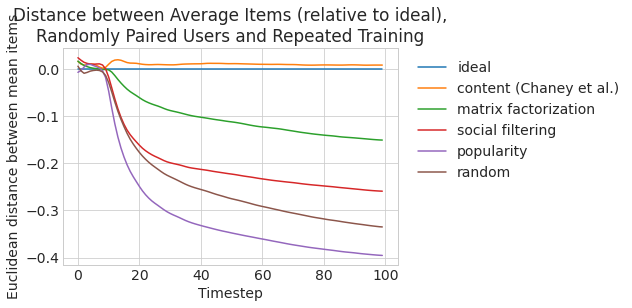

In [118]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Euclidean distance between mean items")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
# plt.ylim(-0.1, 0.3)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Repeated Training")
plt.savefig('creator_repeated_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

## Change in Mean Item Distance (similar users paired)

In [119]:
# get change in jaccard index just for ideal recommender
relative_dist = {}
relative_dist["ideal"] = np.zeros(STARTUP_ITERS + SIM_ITERS)

for model_key in model_keys:
    if model_key is not "ideal":
        relative_dist[model_key] = (np.array(rep_train_results["sim_user_dist"][model_key])).mean(axis=0) # average across 10 trials

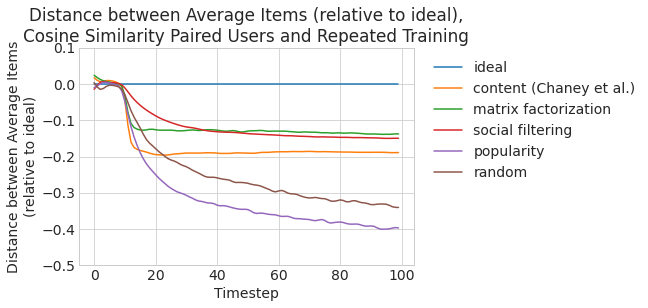

In [120]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nCosine Similarity Paired Users and Repeated Training")
plt.savefig('creator_repeated_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")

# Single training

We do the same training with all of the same models just as we did earlier, but now we only train each model once - following the startup phase.

In [ ]:
# stores results for each type of model for each type of user pairing (random or cosine similarity)
single_train_results = {"mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}
single_train_models = {}

STARTUP_ITERS = 50
SIM_ITERS = 50

for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    creator_profiles = creators[i]
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
        
    repeated_training = False
    single_train_models["ideal"] = run_ideal_sim(true_prefs, creator_profiles, pairs, repeated_training)
    ideal_interactions = np.hstack(process_measurement(single_train_models["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    ideal_attrs = single_train_models["ideal"].actual_item_attributes
    single_train_models["content_chaney"] = run_content_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, repeated_training)
    single_train_models["mf"] = run_mf_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, repeated_training)
    single_train_models["sf"] = run_sf_sim(social_network, true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, repeated_training)
    single_train_models["popularity"] = run_pop_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, repeated_training)
    single_train_models["random"] = run_random_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, repeated_training)
    
    # extract results from each model
    for model_key in model_keys:
        model = single_train_models[model_key]
        single_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            single_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

 92%|█████████▏| 46/50 [00:02<00:00, 13.97it/s]

## Average distance between mean items

In [ ]:
# get change in jaccard index just for ideal recommender
ideal_dist = np.array(single_train_results["mean_item_dist"]["ideal"])
relative_dist = {}

for model_key in model_keys:
    abs_dist = np.array(single_train_results["mean_item_dist"][model_key])
    relative_dist[model_key] = (abs_dist - ideal_dist).mean(axis=0) # average across 10 trials

In [ ]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Euclean distance between mean items")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.3, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Single Training")
plt.savefig('creator_single_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

## Change in Mean Item Distance (similar users paired)

In [ ]:
# get change in jaccard index just for ideal recommender
relative_dist = {}
relative_dist["ideal"] = np.zeros(STARTUP_ITERS + SIM_ITERS)

for model_key in model_keys:
    if model_key is not "ideal":
        relative_dist[model_key] = (np.array(single_train_results["sim_user_dist"][model_key])).mean(axis=0) # average across 10 trials

In [ ]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nCosine Similarity Paired Users and Single Training")
plt.savefig('creator_single_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")

[0.0011 0.0009 0.0011 0.001  0.0009 0.001  0.0011 0.0011 0.0013 0.001
 0.0009 0.001  0.0011 0.001  0.0011 0.001  0.0009 0.001  0.001  0.0011
 0.0013 0.0009 0.001  0.001  0.0009 0.0009 0.0009 0.001  0.0009 0.0009
 0.001  0.001  0.0009 0.001  0.0009 0.0011 0.001  0.0011 0.001  0.001
 0.001  0.001  0.001  0.0011 0.0011 0.0009 0.0009 0.0009 0.0009 0.001
 0.001  0.0009 0.001  0.001  0.0009 0.0009 0.001  0.0011 0.0009 0.001
 0.0009 0.0011 0.0011 0.0008 0.001  0.0008 0.001  0.0011 0.0012 0.0011
 0.001  0.001  0.001  0.0011 0.0009 0.0011 0.001  0.0011 0.001  0.0012
 0.0009 0.001  0.0009 0.0011 0.001  0.001  0.001  0.0011 0.0009 0.001
 0.0009 0.0011 0.0009 0.001  0.001  0.0009 0.0009 0.0011 0.0009 0.001 ]
8


(array([1., 0., 1., 0., 0., 1., 1., 2., 2., 3., 5., 4., 2., 1., 4., 5., 4.,
        3., 3., 5., 4., 5., 3., 2., 7., 3., 2., 3., 3., 1., 2., 1., 2., 7.,
        1., 2., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.]),
 array([0.0008011 , 0.00081042, 0.00081973, 0.00082904, 0.00083836,
        0.00084767, 0.00085698, 0.0008663 , 0.00087561, 0.00088493,
        0.00089424, 0.00090355, 0.00091287, 0.00092218, 0.00093149,
        0.00094081, 0.00095012, 0.00095943, 0.00096875, 0.00097806,
        0.00098737, 0.00099669, 0.001006  , 0.00101531, 0.00102463,
        0.00103394, 0.00104325, 0.00105257, 0.00106188, 0.00107119,
        0.00108051, 0.00108982, 0.00109913, 0.00110845, 0.00111776,
        0.00112707, 0.00113639, 0.0011457 , 0.00115502, 0.00116433,
        0.00117364, 0.00118296, 0.00119227, 0.00120158, 0.0012109 ,
        0.00122021, 0.00122952, 0.00123884, 0.00124815, 0.00125746,
        0.00126678]),
 <BarContainer object of 50 artists>)

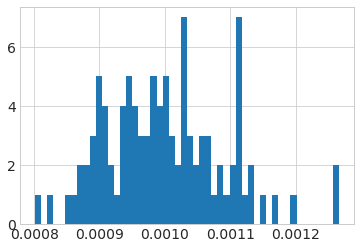

In [143]:
# playing around w dirichlet
x = np.random.dirichlet(np.ones(100) * 100 ) * 0.1
print(np.round(x, decimals=4))
print(np.argmax(x))
plt.hist(x, bins=50)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
72


(array([99.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.01999999, 0.03999998, 0.05999996, 0.07999995,
        0.09999994, 0.11999993, 0.13999992, 0.15999991, 0.17999989,
        0.19999988, 0.21999987, 0.23999986, 0.25999985, 0.27999984,
        0.29999982, 0.31999981, 0.3399998 , 0.35999979, 0.37999978,
        0.39999977, 0.41999975, 0.43999974, 0.45999973, 0.47999972,
        0.49999971, 0.5199997 , 0.53999968, 0.55999967, 0.57999966,
        0.59999965, 0.61999964, 0.63999962, 0.65999961, 0.6799996 ,
        0.69999959, 0.71999958, 0.73999957, 0.75999955, 0.77999954,
        0.79999953, 0.81999952, 0.83999951, 0.8599995 , 0.87999948,
        0.89999947, 0.91999946, 0.93999945, 0.95999944, 0.97999943,
        0.99999941]),
 <BarContainer

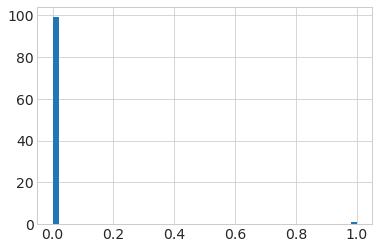

In [148]:
y = np.random.dirichlet(x)
print(np.round(y, decimals=2))
print(np.argmax(y))
plt.hist(y, bins=50)

In [20]:
orig = np.random.dirichlet(np.ones(10) * 10) # * 100
print("Original template for dirichlet:")
print(np.round(orig, decimals=3))

print("Generated by template:")
temp = orig
for i in range(20):
    print(f"i={i}")
    print(np.round(temp, decimals=3))
    for j in range(5):
        temp2 = np.random.dirichlet(temp * 0.1) 
        print(f"\t Item generated by i={i}")
        print(f"\t{np.round(temp2, decimals=3)}")
    print()
    temp += temp2
    temp /= np.linalg.norm(temp)
    print(temp.sum())

# z = np.zeros(10) + 0.0001
# z[2] = 0.1
# z *= 10000000
# a = np.random.dirichlet(z)
# print(np.round(a, decimals=3))
# b = np.random.dirichlet(a)
# print(np.round(b, decimals=3))
# a += 0.05 * b
# print(np.round(np.random.dirichlet(a), decimals=3))
# # jumbled thoughts - what if 

Original template for dirichlet:
[0.077 0.122 0.064 0.126 0.126 0.088 0.117 0.116 0.11  0.054]
Generated by template:
i=0
[0.077 0.122 0.064 0.126 0.126 0.088 0.117 0.116 0.11  0.054]
	 Item generated by i=0
	[0.206 0.    0.    0.    0.794 0.    0.    0.    0.    0.   ]
	 Item generated by i=0
	[0.    0.    0.794 0.    0.014 0.    0.    0.    0.192 0.   ]
	 Item generated by i=0
	[0.    0.    0.    0.    0.    0.    0.311 0.689 0.    0.   ]
	 Item generated by i=0
	[0.    0.    0.    0.    0.    0.003 0.    0.    0.997 0.   ]
	 Item generated by i=0
	[0.    0.01  0.    0.    0.    0.003 0.986 0.    0.    0.   ]

1.744806555175702
i=1
[0.067 0.115 0.056 0.11  0.11  0.08  0.963 0.101 0.096 0.047]
	 Item generated by i=1
	[0.    0.    0.    0.    0.    0.    0.018 0.    0.982 0.   ]
	 Item generated by i=1
	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
	 Item generated by i=1
	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
	 Item generated by i=1
	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
	 Item generated by i=1
	[0.    0.    